In [2]:
from spectral_cube import SpectralCube as sc
from astropy import units as u
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
from astropy import wcs
import matplotlib 
from scipy.optimize import curve_fit
from pvextractor import extract_pv_slice, Path
import copy
import re
import pandas as pd
import os 
import astropy.constants as ct
import matplotlib.lines as mlines


In [3]:
def rest2measfreq(restfreq, vlsr):
    rest = restfreq*u.MHz         # restfreq in MHz   vlsr in km/s
    radio_equiv = u.doppler_radio(rest)
    vel = vlsr*u.km/u.s
    shiftfreq = vel.to(u.MHz, equivalencies=radio_equiv)  # shiftfreq in MHz
    return shiftfreq 



In [4]:
contfile_list = './TM1cont_filelist.txt'
cubefile_list = './TM1cube_filelist.txt'

f = open(contfile_list, 'r')
contfiles = f.readlines()
f.close()
contfiles = [s.rstrip('\n') for s in contfiles]


f = open(cubefile_list, 'r')
cubefiles = f.readlines()
f.close()
cubefiles = [s.rstrip('\n') for s in cubefiles]

# pattern = r'I\d{5}[-+p]\d{4}'
# sources = [re.findall(pattern, s)[0] for s in contfiles]
# sources_ptoplus = [s.replace('p', '+') for s in sources]

source_info = np.genfromtxt('./sourcetable.csv', comments='#',dtype=None, delimiter=',')

source = 'I17589-2312'
source_info_cell = next((c for c in source_info if c[1] == source.encode('utf-8')), None)
vlsr = source_info_cell[7]
contfile = [string for string in contfiles if source in string][0]  # find the fits file
cubefile = [string for string in cubefiles if source in string][0]


if not os.path.exists('./%s'%source):
    os.makedirs('./%s'%source)



/tmp/ipykernel_2453268/720211844.py:19: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  source_info = np.genfromtxt('./sourcetable.csv', comments='#',dtype=None, delimiter=',')


# SO

/home/mxf/.conda/envs/scousepy/lib/python3.12/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


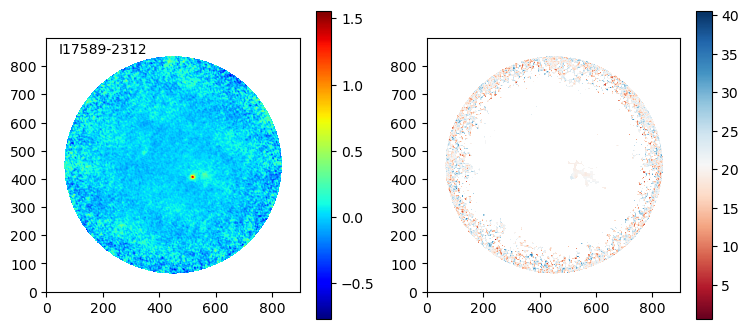

In [5]:
cube = sc.read(cubefile).with_spectral_unit(u.km/u.s, velocity_convention='radio',
                                                        rest_value=219.949442*u.GHz)
rms = np.std(cube.subcube(250,650,250,650,0,1)[0,:,:])*1.2  # mxf: take a center box of the first channel to compute the noise... any better solution for this?
SO_cube = cube.spectral_slab((vlsr-20)*u.km/u.s, (vlsr+20)*u.km/u.s)
SO_cube_masked = SO_cube.with_mask(SO_cube > 3*rms)

mom0 = SO_cube.moment0()
mom1 = SO_cube_masked.moment1()
mom0.write('./%s/%s_SO_mom0.fits'%(source, source), overwrite=True)
mom1.write('./%s/%s_SO_mom1.fits'%(source, source), overwrite=True)

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(mom0.array,origin='lower', cmap='jet')
plt.text(0.05,0.94, source,transform=plt.gca().transAxes)
plt.colorbar()
plt.subplot(122)
plt.imshow(mom1.array,origin='lower',cmap='RdBu')
plt.colorbar()


(61, 900, 900)

In [ ]:
cont_hdu = fits.open(contfile)[0]
cont_wcs = wcs.WCS(cont_hdu.header, naxis=2)
cont_image = np.squeeze(cont_hdu.data)
cont_rms = 3e-4
cont_levels = np.array([3,5,7,9,12,15,20,50,100])
hdul = fits.HDUList([cont_hdu])
cont_hdu.writeto('./%s/%s_cont.fits'%(source, source), overwrite=True)  
################################################################################

mom0fitspath = './%s/%s_SO_mom0.fits'%(source, source)
hdu1 = fits.open(mom0fitspath)[0]
wcs1 = wcs.WCS(hdu1.header, naxis=2)
image1 = np.squeeze(hdu1.data)

mom1fitspath = './%s/%s_SO_mom1.fits'%(source, source)
hdu2 = fits.open(mom1fitspath)[0]
wcs2 = wcs.WCS(hdu2.header, naxis=2)
image2 = np.squeeze(hdu2.data)

################################################################################
fig = plt.figure(figsize=[10,5])

ax = plt.subplot(1,2,1, projection=wcs1)
# ax.imshow(image1, origin='lower', vmin=1e-1, vmax=4e-1)
im = ax.imshow(image1, origin='lower', cmap='jet')
ax.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='k', linewidths=0.8)
ax.set_xlabel('Right Ascension', fontsize=15)
ax.set_ylabel('Declination', fontsize=15)
ax.tick_params(labelsize = 10)


rect = [0.15, 0.88, 0.3, 0.02] 
cax = fig.add_axes(rect)
cb = fig.colorbar(im, orientation='horizontal',cax=cax)
cb.ax.tick_params(direction='out', top=True, bottom=False)
cb.set_label(r'Intensity', fontsize=13, loc='center')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(axis='x',labelbottom=False, length=0)
cb.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

################################################################################
vmin, vmax = vlsr-4, vlsr+4
ax1 = plt.subplot(1,2,2, projection=wcs1)
im1 = ax1.imshow(image2, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='black', linewidths=0.8)
ax1.set_xlabel('Right Ascension', fontsize=15)
ax1.set_ylabel(' ', fontsize=15)
ax1.tick_params(labelsize = 10)


rect1 = [0.55, 0.88, 0.3, 0.02] 
cax1 = fig.add_axes(rect1)
cb1 = fig.colorbar(im1, orientation='horizontal',cax=cax1)
cb1.ax.tick_params(direction='out', top=True, bottom=False)
cb1.set_label(r'V$_{\rm LSR}$ [km s$^{-1}$]', fontsize=13, loc='center')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.tick_params(axis='x',labelbottom=False, length=0)
cb1.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

peaky, peakx = np.unravel_index(np.argmax(np.nan_to_num(image1)), image1.shape)
xl, xr = peakx-60, peakx+120
yd, yu = peaky-60, peaky+120
ax.set_xlim([xl,xr])
ax.set_ylim([yd,yu])
ax1.set_xlim([xl,xr])
ax1.set_ylim([yd,yu])

# plt.savefig('./%s/%s_SO_mom01.pdf'%(source, source), dpi=300, bbox_inches='tight')

(383.0, 433.0)

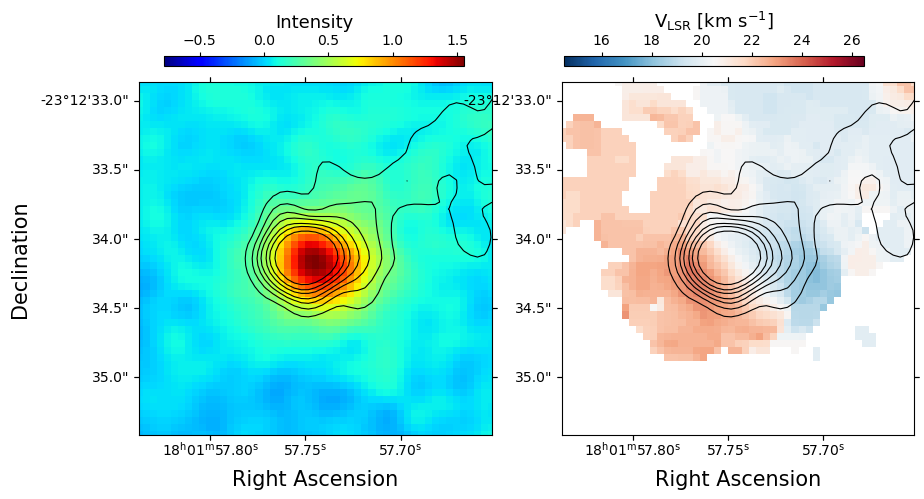

In [184]:
cont_hdu = fits.open(contfile)[0]
cont_wcs = wcs.WCS(cont_hdu.header, naxis=2)
cont_image = np.squeeze(cont_hdu.data)
cont_rms = 3e-4
cont_levels = np.array([3,5,7,9,12,15,20,50,100])
hdul = fits.HDUList([cont_hdu])
cont_hdu.writeto('./%s/%s_cont.fits'%(source, source), overwrite=True)  
################################################################################

mom0fitspath = './%s/%s_SO_mom0.fits'%(source, source)
hdu1 = fits.open(mom0fitspath)[0]
wcs1 = wcs.WCS(hdu1.header, naxis=2)
image1 = np.squeeze(hdu1.data)

mom1fitspath = './%s/%s_SO_mom1.fits'%(source, source)
hdu2 = fits.open(mom1fitspath)[0]
wcs2 = wcs.WCS(hdu2.header, naxis=2)
image2 = np.squeeze(hdu2.data)

################################################################################
fig = plt.figure(figsize=[10,5])

ax = plt.subplot(1,2,1, projection=wcs1)
# ax.imshow(image1, origin='lower', vmin=1e-1, vmax=4e-1)
im = ax.imshow(image1, origin='lower', cmap='jet')
ax.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='k', linewidths=0.8)
ax.set_xlabel('Right Ascension', fontsize=15)
ax.set_ylabel('Declination', fontsize=15)
ax.tick_params(labelsize = 10)


rect = [0.15, 0.88, 0.3, 0.02] 
cax = fig.add_axes(rect)
cb = fig.colorbar(im, orientation='horizontal',cax=cax)
cb.ax.tick_params(direction='out', top=True, bottom=False)
cb.set_label(r'Intensity', fontsize=13, loc='center')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(axis='x',labelbottom=False, length=0)
cb.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

################################################################################
vmin, vmax = vlsr-6, vlsr+6
ax1 = plt.subplot(1,2,2, projection=wcs1)
im1 = ax1.imshow(image2, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='black', linewidths=0.8)
ax1.set_xlabel('Right Ascension', fontsize=15)
ax1.set_ylabel(' ', fontsize=15)
ax1.tick_params(labelsize = 10)


rect1 = [0.55, 0.88, 0.3, 0.02] 
cax1 = fig.add_axes(rect1)
cb1 = fig.colorbar(im1, orientation='horizontal',cax=cax1)
cb1.ax.tick_params(direction='out', top=True, bottom=False)
cb1.set_label(r'V$_{\rm LSR}$ [km s$^{-1}$]', fontsize=13, loc='center')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.tick_params(axis='x',labelbottom=False, length=0)
cb1.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

peaky, peakx = np.unravel_index(np.argmax(np.nan_to_num(image1)), image1.shape)
xl, xr = peakx-25, peakx+25
yd, yu = peaky-25, peaky+25
ax.set_xlim([xl,xr])
ax.set_ylim([yd,yu])
ax1.set_xlim([xl,xr])
ax1.set_ylim([yd,yu])

# plt.savefig('./%s/%s_SO_mom01.pdf'%(source, source), dpi=300, bbox_inches='tight')

In [ ]:
# ch3cn_cube = sc.read('I18134_CH3CN.fits')
# ch3cn_cube = ch3cn_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
# ch3cn_cube = sc.read('I18134_spw1.fits')

mom1fitspath = './%s/%s_SO_mom1.fits'%(source, source)
mom1_hdu = fits.open(mom1fitspath)[0]
mom1_wcs = wcs.WCS(mom1_hdu.header, naxis=2)
mom1_image = np.squeeze(mom1_hdu.data)

start_end = [(499, 394), (541, 419)]
path = Path(start_end, width=5)
pv = extract_pv_slice(cube=SO_cube, path=path)
# pv.writeto('./%s/%s_SO_pv.fits'%(source, source))


In [ ]:
fig = plt.figure(figsize=[10,5])

### Plot Mom_1
ax1 = plt.subplot(121, projection=mom1_wcs)
# ax.imshow(image1, origin='lower', vmin=1e-1, vmax=4e-1)
im1 = ax1.imshow(mom1_image, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='black', linewidths=0.8)
ax1.set_xlabel('RA', fontsize=15)
ax1.set_ylabel('Dec', fontsize=15)
ax1.tick_params(labelsize = 10)

rect1 = [0.15, 0.86, 0.3, 0.02] 
cax1 = fig.add_axes(rect1)
cb1 = fig.colorbar(im1, orientation='horizontal',cax=cax1)
cb1.ax.tick_params(direction='out', top=True, bottom=False)
cb1.set_label(r'V$_{\rm LSR}$ [km s$^{-1}$]', fontsize=13, loc='center')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.tick_params(axis='x',labelbottom=False, length=0)
cb1.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

# xl, xr = 500, 600
# yd, yu = 300, 400
ax1.set_xlim([xl,xr])
ax1.set_ylim([yd,yu])

path.show_on_axis(ax1, spacing=5, color='r', alpha=0.5)

### Plot Position - Velocity Diagram
rms_ref = rms
pv_levels = np.array([3,7,15, 22,30])

w_pv = wcs.WCS(pv.header)
ax2 = plt.subplot(122, projection=w_pv)
im2 = ax2.imshow(pv.data, cmap='rainbow')
ax2.contour(pv.data, levels=pv_levels*rms_ref, colors='w')

ax2.set_aspect(1)
ax2_x = ax2.coords[0]
ax2_x.set_format_unit(u.arcsec)
ax2_y = ax2.coords[1]
ax2_y.set_format_unit(u.km/u.s)

# plt.savefig('./%s/%s_SO_pv.pdf'%(source, source), dpi=300, bbox_inches='tight')

# 13CO

/home/mxf/.conda/envs/scousepy/lib/python3.12/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


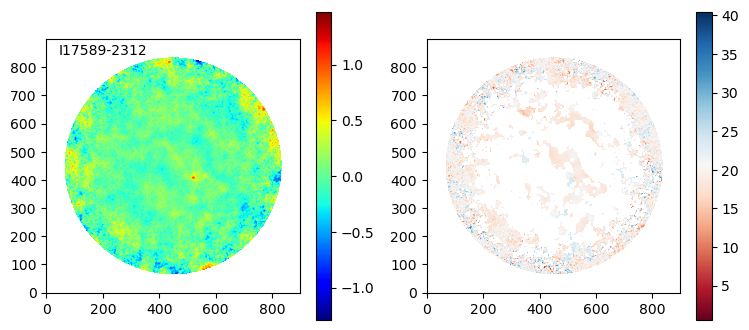

In [5]:
cube = sc.read(cubefile).with_spectral_unit(u.km/u.s, velocity_convention='radio',
                                                        rest_value=220.3986765*u.GHz)
rms = np.std(cube.subcube(250,650,250,650,0,1)[0,:,:])*1.5  # mxf: take a center box of the first channel to compute the noise... any better solution for this?
CO_cube = cube.spectral_slab((vlsr-20)*u.km/u.s, (vlsr+20)*u.km/u.s)
CO_cube_masked = CO_cube.with_mask(CO_cube > 3*rms)

mom0 = CO_cube.moment0()
mom1 = CO_cube_masked.moment1()
mom0.write('./%s/%s_CO_mom0.fits'%(source, source), overwrite=True)
mom1.write('./%s/%s_CO_mom1.fits'%(source, source), overwrite=True)

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(mom0.array,origin='lower', cmap='jet')
plt.text(0.05,0.94, source,transform=plt.gca().transAxes)
plt.colorbar()
plt.subplot(122)
plt.imshow(mom1.array,origin='lower',cmap='RdBu')
plt.colorbar()


(384.0, 434.0)

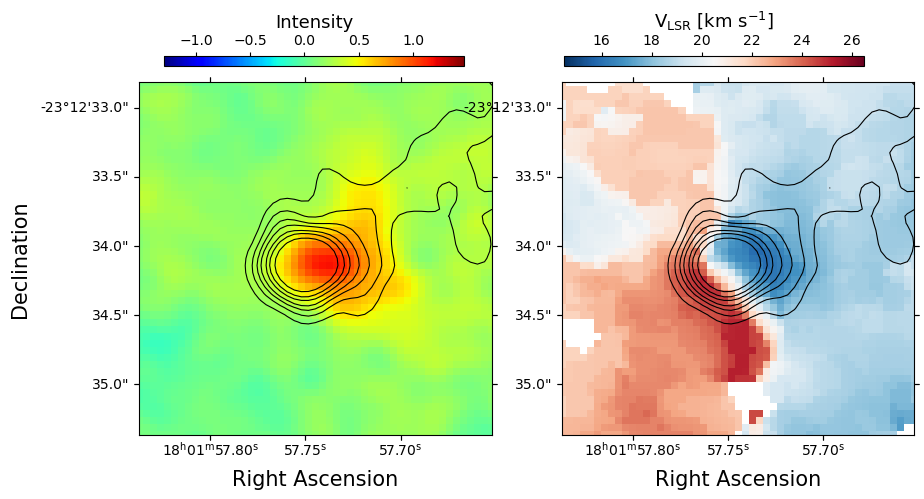

In [183]:
cont_hdu = fits.open(contfile)[0]
cont_wcs = wcs.WCS(cont_hdu.header, naxis=2)
cont_image = np.squeeze(cont_hdu.data)
cont_rms = 3e-4
cont_levels = np.array([3,5,7,9,12,15,20,50,100])
hdul = fits.HDUList([cont_hdu])
cont_hdu.writeto('./%s/%s_cont.fits'%(source, source), overwrite=True)  
################################################################################

mom0fitspath = './%s/%s_CO_mom0.fits'%(source, source)
hdu1 = fits.open(mom0fitspath)[0]
wcs1 = wcs.WCS(hdu1.header, naxis=2)
image1 = np.squeeze(hdu1.data)

mom1fitspath = './%s/%s_CO_mom1.fits'%(source, source)
hdu2 = fits.open(mom1fitspath)[0]
wcs2 = wcs.WCS(hdu2.header, naxis=2)
image2 = np.squeeze(hdu2.data)

################################################################################
fig = plt.figure(figsize=[10,5])

ax = plt.subplot(1,2,1, projection=wcs1)
# ax.imshow(image1, origin='lower', vmin=1e-1, vmax=4e-1)
im = ax.imshow(image1, origin='lower', cmap='jet')
ax.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='k', linewidths=0.8)
ax.set_xlabel('Right Ascension', fontsize=15)
ax.set_ylabel('Declination', fontsize=15)
ax.tick_params(labelsize = 10)


rect = [0.15, 0.88, 0.3, 0.02] 
cax = fig.add_axes(rect)
cb = fig.colorbar(im, orientation='horizontal',cax=cax)
cb.ax.tick_params(direction='out', top=True, bottom=False)
cb.set_label(r'Intensity', fontsize=13, loc='center')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(axis='x',labelbottom=False, length=0)
cb.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

################################################################################
vmin, vmax = vlsr-6, vlsr+6
ax1 = plt.subplot(1,2,2, projection=wcs1)
im1 = ax1.imshow(image2, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='black', linewidths=0.8)
ax1.set_xlabel('Right Ascension', fontsize=15)
ax1.set_ylabel(' ', fontsize=15)
ax1.tick_params(labelsize = 10)


rect1 = [0.55, 0.88, 0.3, 0.02] 
cax1 = fig.add_axes(rect1)
cb1 = fig.colorbar(im1, orientation='horizontal',cax=cax1)
cb1.ax.tick_params(direction='out', top=True, bottom=False)
cb1.set_label(r'V$_{\rm LSR}$ [km s$^{-1}$]', fontsize=13, loc='center')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.tick_params(axis='x',labelbottom=False, length=0)
cb1.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

# peaky, peakx = np.unravel_index(np.argmax(np.nan_to_num(image1)), image1.shape)
peaky, peakx = 409, 519
xl, xr = peakx-25, peakx+25
yd, yu = peaky-25, peaky+25
ax.set_xlim([xl,xr])
ax.set_ylim([yd,yu])
ax1.set_xlim([xl,xr])
ax1.set_ylim([yd,yu])

# plt.savefig('./%s/%s_SO_mom01.pdf'%(source, source), dpi=300, bbox_inches='tight')

In [ ]:
cont_hdu = fits.open(contfile)[0]
cont_wcs = wcs.WCS(cont_hdu.header, naxis=2)
cont_image = np.squeeze(cont_hdu.data)
cont_rms = 3e-4
cont_levels = np.array([3,5,7,9,12,15,20,50,100])
hdul = fits.HDUList([cont_hdu])
cont_hdu.writeto('./%s/%s_cont.fits'%(source, source), overwrite=True)  
################################################################################

mom0fitspath = './%s/%s_CO_mom0.fits'%(source, source)
hdu1 = fits.open(mom0fitspath)[0]
wcs1 = wcs.WCS(hdu1.header, naxis=2)
image1 = np.squeeze(hdu1.data)

mom1fitspath = './%s/%s_CO_mom1.fits'%(source, source)
hdu2 = fits.open(mom1fitspath)[0]
wcs2 = wcs.WCS(hdu2.header, naxis=2)
image2 = np.squeeze(hdu2.data)

################################################################################
fig = plt.figure(figsize=[10,5])

ax = plt.subplot(1,2,1, projection=wcs1)
# ax.imshow(image1, origin='lower', vmin=1e-1, vmax=4e-1)
im = ax.imshow(image1, origin='lower', cmap='jet')
ax.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='k', linewidths=0.8)
ax.set_xlabel('Right Ascension', fontsize=15)
ax.set_ylabel('Declination', fontsize=15)
ax.tick_params(labelsize = 10)


rect = [0.15, 0.88, 0.3, 0.02] 
cax = fig.add_axes(rect)
cb = fig.colorbar(im, orientation='horizontal',cax=cax)
cb.ax.tick_params(direction='out', top=True, bottom=False)
cb.set_label(r'Intensity', fontsize=13, loc='center')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(axis='x',labelbottom=False, length=0)
cb.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

################################################################################
vmin, vmax = vlsr-4, vlsr+4
ax1 = plt.subplot(1,2,2, projection=wcs1)
im1 = ax1.imshow(image2, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='black', linewidths=0.8)
ax1.set_xlabel('Right Ascension', fontsize=15)
ax1.set_ylabel(' ', fontsize=15)
ax1.tick_params(labelsize = 10)


rect1 = [0.55, 0.88, 0.3, 0.02] 
cax1 = fig.add_axes(rect1)
cb1 = fig.colorbar(im1, orientation='horizontal',cax=cax1)
cb1.ax.tick_params(direction='out', top=True, bottom=False)
cb1.set_label(r'V$_{\rm LSR}$ [km s$^{-1}$]', fontsize=13, loc='center')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.tick_params(axis='x',labelbottom=False, length=0)
cb1.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

peaky, peakx = 409, 519
xl, xr = peakx-60, peakx+120
yd, yu = peaky-60, peaky+120
ax.set_xlim([xl,xr])
ax.set_ylim([yd,yu])
ax1.set_xlim([xl,xr])
ax1.set_ylim([yd,yu])

# plt.savefig('./%s/%s_SO_mom01.pdf'%(source, source), dpi=300, bbox_inches='tight')

In [ ]:
mom1fitspath = './%s/%s_SO_mom1.fits'%(source, source)
mom1_hdu = fits.open(mom1fitspath)[0]
mom1_wcs = wcs.WCS(mom1_hdu.header, naxis=2)
mom1_image = np.squeeze(mom1_hdu.data)

start_end = [(499, 394), (541, 419)]
path = Path(start_end, width=5)
pv = extract_pv_slice(cube=CO_cube, path=path)
pv.writeto('./%s/%s_CO_pv.fits'%(source, source))


In [ ]:
fig = plt.figure(figsize=[10,5])

### Plot Mom_1
ax1 = plt.subplot(121, projection=mom1_wcs)
# ax.imshow(image1, origin='lower', vmin=1e-1, vmax=4e-1)
im1 = ax1.imshow(mom1_image, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='black', linewidths=0.8)
ax1.set_xlabel('RA', fontsize=15)
ax1.set_ylabel('Dec', fontsize=15)
ax1.tick_params(labelsize = 10)

rect1 = [0.15, 0.86, 0.3, 0.02] 
cax1 = fig.add_axes(rect1)
cb1 = fig.colorbar(im1, orientation='horizontal',cax=cax1)
cb1.ax.tick_params(direction='out', top=True, bottom=False)
cb1.set_label(r'V$_{\rm LSR}$ [km s$^{-1}$]', fontsize=13, loc='center')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.tick_params(axis='x',labelbottom=False, length=0)
cb1.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

peaky, peakx = 409, 519
xl, xr = peakx-25, peakx+25
yd, yu = peaky-25, peaky+25
ax.set_xlim([xl,xr])
ax.set_ylim([yd,yu])
ax1.set_xlim([xl,xr])
ax1.set_ylim([yd,yu])

path.show_on_axis(ax1, spacing=5, color='r', alpha=0.5)

### Plot Position - Velocity Diagram
rms_ref = rms
pv_levels = np.array([3,7,15, 22,30])

w_pv = wcs.WCS(pv.header)
ax2 = plt.subplot(122, projection=w_pv)
im2 = ax2.imshow(pv.data, cmap='rainbow')
ax2.contour(pv.data, levels=pv_levels*rms_ref, colors='w')

ax2.set_aspect(1)
ax2_x = ax2.coords[0]
ax2_x.set_format_unit(u.arcsec)
ax2_y = ax2.coords[1]
ax2_y.set_format_unit(u.km/u.s)

plt.savefig('./%s/%s_CO_pv.pdf'%(source, source), dpi=300, bbox_inches='tight')

In [132]:
def GetKeplerianCurve(xoffset, Msin, reverse = False):
    xoffset = xoffset * u.au
    Msin = Msin * ct.M_sun
    xoffset_abs = np.abs(xoffset)
    vrad = np.sqrt(ct.G*Msin/xoffset_abs)
    mask = (xoffset < 0)
    vrad[mask] = vrad[mask] * (-1)
    if reverse:
        vrad = -vrad
    return vrad.to(u.km/u.s)

def GetRigidRotation(xoffset, omega,reverse=False):
    xoffset = xoffset * u.au   # in au
    omega = omega / u.yr     # Angular velocity in rad/yr
    linear_velocity = xoffset*omega
    if reverse:
        linear_velocity = -linear_velocity
    return linear_velocity.to(u.km/u.s)
    

<>:51: SyntaxWarning: invalid escape sequence '\o'
<>:52: SyntaxWarning: invalid escape sequence '\o'
<>:53: SyntaxWarning: invalid escape sequence '\o'
<>:51: SyntaxWarning: invalid escape sequence '\o'
<>:52: SyntaxWarning: invalid escape sequence '\o'
<>:53: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2069678/1558833235.py:51: SyntaxWarning: invalid escape sequence '\o'
  line1 = ax.plot(xoffset_position, vrad1_pix, 'k--', label = r'M sin$~i$='+ str(Msin[0]) +' $M_{\odot}$', linewidth=3)
/tmp/ipykernel_2069678/1558833235.py:52: SyntaxWarning: invalid escape sequence '\o'
  line2 = ax.plot(xoffset_position, vrad2_pix, 'k-.', label = r'M sin$~i$='+ str(Msin[1]) +' $M_{\odot}$', linewidth=3)
/tmp/ipykernel_2069678/1558833235.py:53: SyntaxWarning: invalid escape sequence '\o'
  line3 = ax.plot(xoffset_position, vrad3_pix, 'k', label = r'M sin$~i$='+ str(Msin[2]) +' $M_{\odot}$', linewidth=3)
/home/mxf/.conda/envs/scousepy/lib/python3.12/site-packages/astropy/units/quantit

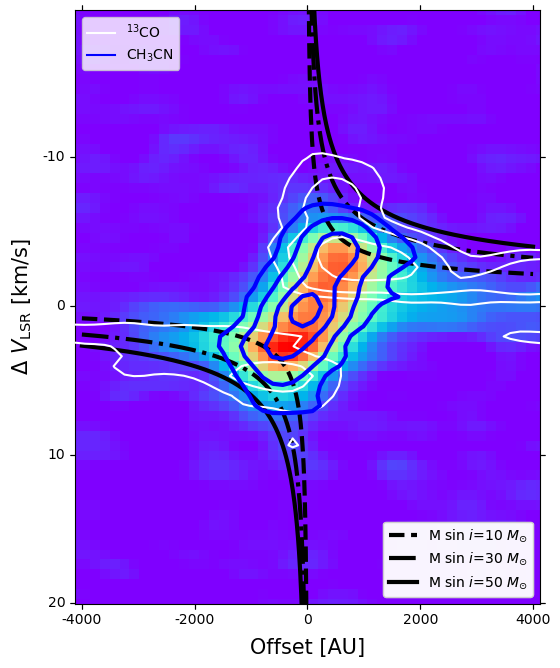

In [182]:
# physc_range = (physc_range - pvheader['CRVAL1'])/pvheader['CDELT1'] + pvheader['CRPIX1']

dist = 3440  # pc


pv_so = fits.open('./%s/%s_SO_pv.fits'%(source, source))[0]
pv_co = fits.open('./%s/%s_CO_pv.fits'%(source, source))[0]
pv_ch3cn = fits.open('./%s/%s_CH3CN_pv.fits'%(source, source))[0]

pvheader = pv_so.header
pvheader['CRVAL2'] = pvheader['CRVAL2'] - (vlsr)*1000
pvheader['CRVAL1'] = pvheader['CRVAL1'] - ((pvheader['NAXIS1']-1)*pvheader['CDELT1']/2)
xlabel_au = np.array([-4000,-3000,-2000,-1000,0,1000,2000,3000,4000])
xlabel_as = xlabel_au/206265/dist/np.pi*180*3600
xlabeltick_position = (xlabel_as/3600-pvheader['CRVAL1'])/pvheader['CDELT1']
xlabeltick_au = [str(x) for x in xlabel_au.tolist()]


pvheader['CUNIT1'] = 'AU'
pvheader['CDELT1'] = pvheader['CDELT1']*np.pi/180*dist*206265  # au
pvheader['CRVAL1'] = pvheader['CRVAL1']*np.pi/180*dist*206265  # au

xoffset = np.arange(-4000,4001,10)  # AU
xoffset_position =  (xoffset - pvheader['CRVAL1'])/pvheader['CDELT1']
xoffset_rg = np.arange(-1100,1101,300)  # AU
xoffset_rg_position =  (xoffset_rg - pvheader['CRVAL1'])/pvheader['CDELT1']
omega = 1.3e-3 # rad/yr

Msin = [10,30,50]    # solar mass
vrad1 = GetKeplerianCurve(xoffset, Msin[0], reverse=True)
vrad1_pix = (vrad1.value*1000 - pvheader['CRVAL2'])/pvheader['CDELT2'] + pvheader['CRPIX2']
vrad2 = GetKeplerianCurve(xoffset, Msin[1], reverse=True)
vrad2_pix = (vrad2.value*1000 - pvheader['CRVAL2'])/pvheader['CDELT2'] + pvheader['CRPIX2']
vrad3 = GetKeplerianCurve(xoffset, Msin[2], reverse=True)
vrad3_pix = (vrad3.value*1000 - pvheader['CRVAL2'])/pvheader['CDELT2'] + pvheader['CRPIX2']
vrad_rg = GetRigidRotation(xoffset_rg, omega, reverse=True)
vrad_rg_pix = (vrad_rg.value*1000 - pvheader['CRVAL2'])/pvheader['CDELT2'] + pvheader['CRPIX2']



rms_ref = rms
pv_levels_CO = np.array([3,7,15, 22,30])
pv_levels_CH3CN = np.array([3,7,12,15])

fig = plt.figure(figsize=[6,8])
w_pv = wcs.WCS(pvheader)
ax = plt.subplot(111, projection=w_pv)
im = ax.imshow(pv_so.data, cmap='rainbow', vmin=0)
contour1 = ax.contour(pv_co.data, levels=pv_levels*rms_ref, colors='w', label=r'$^{13}$CO', linestyle='-.')
contour2 = ax.contour(pv_ch3cn.data, levels=pv_levels_CH3CN*rms_ref, colors='b', label=r'CH$_3$CN', linestyle='-', linewidths=3)
line1 = ax.plot(xoffset_position, vrad1_pix, 'k--', label = r'M sin$~i$='+ str(Msin[0]) +' $M_{\odot}$', linewidth=3)
line2 = ax.plot(xoffset_position, vrad2_pix, 'k-.', label = r'M sin$~i$='+ str(Msin[1]) +' $M_{\odot}$', linewidth=3)
line3 = ax.plot(xoffset_position, vrad3_pix, 'k', label = r'M sin$~i$='+ str(Msin[2]) +' $M_{\odot}$', linewidth=3)
# line4 = ax.plot(xoffset_rg_position, vrad_rg_pix, 'k-o', label = r'%e rad/yr'%omega, linewidth=3)

contour1_color = contour1.collections[0].get_edgecolor()
contour1_legend = mlines.Line2D([], [], color=contour1_color, label=r'$^{13}$CO')
contour2_color = contour2.collections[0].get_edgecolor()
contour2_legend = mlines.Line2D([], [], color=contour2_color, label=r'CH$_3$CN')


# line_handles = [line1[0], line2[0], line3[0], line4[0]]
line_handles = [line1[0], line2[0], line3[0]]
# line_labels = [r'M sin$~i$='+ str(Msin[0]) +' $M_{\odot}$', r'M sin$~i$='+ str(Msin[1]) +' $M_{\odot}$', r'M sin$~i$='+ str(Msin[2]) +' $M_{\odot}$', r'%.1e rad yr$^{-1}$'%omega]
# line_labels = [r'M sin$~i$='+ str(Msin[0]) +' $M_{\odot}$', r'M sin$~i$='+ str(Msin[1]) +' $M_{\odot}$', r'M sin$~i$='+ str(Msin[2]) +' $M_{\odot}$']

contour_legend = ax.legend(handles = [contour1_legend, contour2_legend], loc='upper left')
line_legend = ax.legend(line_handles, line_labels, loc='lower right')

ax.add_artist(contour_legend)
ax.add_artist(line_legend)

# ax.text(0.9, 0.1, 'SO',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='k', fontsize=15,
#         bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 1, 'boxstyle':'round'}
#         )


ax.set_aspect(1)
ax_x = ax.coords[0]
ax_x.set_format_unit(u.au)
ax_y = ax.coords[1]
ax_y.set_format_unit(u.km/u.s)

ax.set_xticks(xlabeltick_position)
ax.set_xticklabels(xlabeltick_au)

ax.set_xlim(0,pvheader['NAXIS1']-1)
ax.set_ylim(0,pvheader['NAXIS2']-1)

ax.set_xlabel(r'Offset [AU]', fontsize=15)
ax.set_ylabel(r'$\Delta~V_{\rm LSR} $ [km/s]', fontsize=15)

# plt.show()

# ax.set_ylim([10,50])
